## 1. Imports and Paths

In [1]:
# Playing with labeled image data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from kp_descriptor_fns import HarrisKeypointDetector, SimpleFeatureDescriptor, ORB_SIFT_FeatureDescriptor

In [2]:
# Define directories
base_dir = '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
bbox_dir = base_dir + 'data/yolofinalset/obj_train_data/'
ref_dir = base_dir + 'data/logo_references/adidas/'

## 2. Load Example for Dev

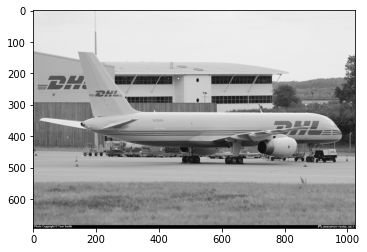

In [3]:
# Load list of train images
with open(base_dir + 'data/yolofinalset/train.txt') as f:
    train = f.readlines()
train = [x.replace('\n', '').split('/')[-1] for x in train]

# Load first image, template, bounding boxes
z = 0
img_file = image_dir + train[z]
img_bbox_file = bbox_dir +  train[z].replace('.jpg', '.txt')

# Read in image as grayscale
im_gray = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
plt.imshow(im_gray, cmap='gray')

## 3. Given image, bbox info.. extract the bounding boxes

# PLACE BELOW INTO FNS SCRIPT

In [ ]:
# Extract bbox subset from image for feature extraction
def extract_bboxes(img_file, img_bbox_file):
    '''Take image and bbox info from roboflow, overlay bbox rectangle on image'''
    
    # Read image, get shape
    im_gray = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    y_shape, x_shape = im_gray.shape[:2]
    im_bboxes = im_gray.copy()

    # Read bbox info, format into cv2 format (needs corner coords)
    with open(img_bbox_file) as f:
        rf_output = f.readlines()

    # unpack, format each box from roboflow output to cv2 corner coords
    bboxes = []
    for box in rf_output:
        # unpack, format roboflow line
        box = box.replace('\n', '')
        box = box.split(' ')
        box = list(map(float, box)) #convert all to floats
        _, mid_x_p, mid_y_p, w_box, h_box = box

        # convert to box corners
        middle_x = int(x_shape*mid_x_p)
        middle_y = int(y_shape*mid_y_p)
        l_x = middle_x - int(x_shape*w_box/2)
        r_x = middle_x + int(x_shape*w_box/2)
        b_y = middle_y + int(y_shape*h_box/2)
        t_y = middle_y - int(y_shape*h_box/2)
        draw_rect = cv2.rectangle(im_bboxes, (l_x, t_y), (r_x, b_y), (0,0,255), 2)
        bboxes.append([l_x, r_x, t_y, b_y]) # save out the bbox corners
    
    return im_gray, im_bboxes, bboxes

im_gray, im_bboxes, bboxes = extract_bboxes(img_file, img_bbox_file)
plt.imshow(im_bboxes, cmap='gray')


#### 3.1 View each box for image

In [ ]:
# Extract a single box so that we can extract features
fig, ax = plt.subplots(len(bboxes), 1, figsize=(5, 10))

all_img_bboxes = np.array([])
for i in range(len(bboxes)):
    x_min, x_max, y_min, y_max = bboxes[i]
    img_bbox = im_bboxes[y_min:y_max, x_min:x_max]
    all_img_bboxes = np.append(all_img_bboxes, img_bbox)
    ax[i].imshow(img_bbox, cmap='gray')

    # get features for each, save each output as it's own row in df

## 4. Feature Extraction - Harris Corners

In [ ]:
# Extract a single box so that we can extract features
i = 1 # box number
x_min, x_max, y_min, y_max = bboxes[i]
img_bbox = im_gray[y_min:y_max, x_min:x_max]

In [ ]:
harris_kp = HarrisKeypointDetector(img_bbox, n=2, w=3, k=0.04, p=0.9, verbose=False)

simple_feature = SimpleFeatureDescriptor(img_bbox, harris_kp, w=5)
harris_orb_feature = ORB_SIFT_FeatureDescriptor(img_bbox, use_orb = True, use_harris=True, nfeatures=10, harris_kp=harris_kp)
orb_kp_feature = ORB_SIFT_FeatureDescriptor(img_bbox, use_orb = True, use_harris=False, nfeatures=10, harris_kp=None)
harris_sift_feature = ORB_SIFT_FeatureDescriptor(img_bbox, use_orb = False, use_harris=True, nfeatures=10, harris_kp=harris_kp)
sift_kp_feature = ORB_SIFT_FeatureDescriptor(img_bbox, use_orb = False, use_harris=False, nfeatures=10, harris_kp=None)